# Carbon-Climate Box Model
## For the moment, land only for PS2

This Jupyter notebook runs the carbon cycle box model for ATMS 588. 

Import Packages

In [1]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import os 
from collections import OrderedDict
from functools import partial

from box_model_functions import co2_emissions, calc_pco2, get_matrix_index, carbon_climate_derivs

## A. Pick a Model Configuration
The __type of model__ you want to run, e.g. land, ocean or coupled land-ocean, is determined by these switches. Before each run these configuration options should be checked and/or modified. 

The __scenario parameters__ are modified in the cell below.

This is where MOST of the modifications you will need to make take place!

In [2]:
PS = OrderedDict()

# Give your run a name
PS['runName'] = 'coupled'

###### Choose if land and ocean should be active (1=active, 0=not active)
PS['DoOcn'] = 0 # include ocean
PS['DoTer'] = 1 # include land

###### For the ocean, choose if each of the pumps should be active (1=active, 0=not active)
PS['DoOcnBio'] = 1 # include ocean biological pump (uptake/remin of Corg)
PS['DoOcnSol'] = 1 # include ocean solubility pump (SST variation)
PS['DoOcnCirc'] = 1 # include ocean solubility pump (SST variation)

###### Choose how carbon-climate coupling (CCC) processes will work (1=active, 0=not active)
PS['DoRadCO2'] = 1 # let climate respond to CO2 changes
PS['CCC_LT'] = 1 # allow CCC via temperature effect on land C (e.g. respiration rate)
PS['CCC_LC'] = 1 # allow CCC via atm co2 effect on land C (e.g. co2 fertilization effect)
PS['CCC_OT'] = 1 # allow CCC via temperature on ocean C (e.g. solubility, circulation)
PS['CCC_OC'] = 1 # allow CCC via atm CO2 effect on ocean C (e.g. disequilibrium, buffer factor)


##### Choose an emissions scheme by specifing the co2 scenario (leave one uncommented)
# escheme = 'zero';
PS['escheme'] = 'rcp85' # emissions trajectory 
# escheme = 'pulse' # emissions trajectory [WARNING: NOT YET CODED]
# escheme = 'ramp1' # co2 trajectory [WARNING: NOT YET CODED]
PS['cmax'] = 4 # co2 change factor used in ramp scenarios (e.g. 4 means 4x[patm0])


###### climate forcing 
# specify climate forcing 
PS['RFamp'] = 0 # amplitude of imposed RF oscillations [W/m2]
PS['RFper'] = 100 # period of oscillatory forcing [yr]

###### Terrestrial ecosystem and forcing

# Specity Ecosystem Type Here
# Options: 'Global', 'TropicalForest', 'TempForest','BorealForest','Grass'
PS['VegName'] = 'Global'

# specify NPP forcing 
PS['NPPamp'] = 0 # fractional amplitude of imposed NPP oscillations (0.5 means 50% change)
PS['NPPper'] = 10 # period of oscillatory forcing [yr]

Setup some structures for the model to use, and specify constants (no need to modify)

In [3]:
# create Dictionary with model setup parameters 
PE = OrderedDict()

PE['re'] = 6371e3 # Earth radius
PE['Ae'] = 4 * np.pi * PE['re']**2; # Earth area
PE['sperd'] = 24 * 60 * 60; # seconds per day
PE['spery'] = PE['sperd'] * 365 # seconds per year
PE['fla'] = 0.3 # fraction land area
PE['foc'] = 1 - PE['fla'] # fraction ocean area
PE['ps'] = 1013.5 * 1e2  # mean surface pressure (Pa)
PE['ma'] = PE['ps'] * PE['Ae'] / 9.80 / 0.0290;   # mass of atmosphere (moles of air)
PE['patm0'] = 280e-6 # preindustrial co2 (atm)

# Structure and Indices of state variable arrays
PE['nd'] = 5 # number state variable 'domains' (Oc Temp, Oc Nutr, Oc CO2, Land C, Atm)
PE['np'] = 9 # number of carbon pools on land
PE['nb'] = 7 # number of boxes in ocean

# generic matrices
PE['m0'] = np.zeros((max(PE['np'],PE['nb']), PE['nd'])) 
PE['m1'] = np.ones((max(PE['np'],PE['nb']), PE['nd']))

arr_row_num = PE['m0'].shape[0]
arr_col_num = PE['m0'].shape[1]
PE['Itmp'] = get_matrix_index(arr_row_num, arr_col_num, np.arange(0, PE['nb']), np.zeros((1, PE['nb']), 
                                                                                         dtype='int'))
PE['Inut'] = get_matrix_index(arr_row_num, arr_col_num, np.arange(0, PE['nb']), np.zeros((1, PE['nb']), 
                                                                                         dtype='int') + 1)
PE['Icoc'] = get_matrix_index(arr_row_num, arr_col_num, np.arange(0, PE['nb']), np.zeros((1, PE['nb']), 
                                                                                         dtype='int') + 2)
PE['Icla'] = get_matrix_index(arr_row_num, arr_col_num, np.arange(0, PE['np']), np.zeros((1, PE['np']), 
                                                                                         dtype='int') + 3)
element_nums = np.arange(0, 9*5).reshape(arr_col_num, arr_row_num).transpose()
PE['Iatm'] = element_nums[0,4]
PE['Ires'] = np.hstack([PE['Itmp'], PE['Inut'], PE['Icoc'], PE['Icla'], PE['Iatm']])

# indices of pools in vector of m0(Ires)
PE['Jtmp'] = np.arange(0, PE['nb']);
PE['Jnut'] = np.arange(PE['nb'], (2 * PE['nb']))
PE['Jcoc'] = np.arange(2 * PE['nb'], 3 * PE['nb'])
PE['Jcla'] = np.arange(3 * PE['nb'], 3 * PE['nb'] + PE['np'])
PE['Jatm'] = PE['Jcla'][-1] + 1

## B. Choose the land parameters
setup land structures and define some parameters

In [4]:
PL = OrderedDict()

#---- pools
PL['iLeaf'] = 0  # leaf
PL['iRoot'] = 1  # root
PL['iWood'] = 2  # wood
PL['iLit1'] = 3  # metabolic litter
PL['iLit2'] = 4  # structural litter
PL['iCWDC'] = 5  # coarse woody debris
PL['iSOM1'] = 6  # soil organic matter 1
PL['iSOM2'] = 7  # soil organic matter 2
PL['iSOM3'] = 8  # soil organic matter 3

# Ae coming from PE struct
PL['Ala'] = PE['Ae'] * PE['fla'] # Land area

# parameters based on case and biomes 

PL['Q10_resp'] = 2
PL['beta_550'] = 1.25
PL['beta_fert'] = (PL['beta_550'] - 1) / np.log(550 / 365)
PL['bcoef'] = np.zeros((PE['np'], 1))
PL['bcoef'][PL['iLeaf']] = 0.30     # leaf
PL['bcoef'][PL['iRoot']] = 0.50     # root

# create tauL array
tauL = np.empty([9], dtype='float')


### Set the timescales (tau) here

In [5]:
# global mean case
if PS['VegName'] == "Global":
    NPP_o = 50    # Net Primary Production [Pg C/yr]
    NPP_o = NPP_o * 1e15 / 12 / PE['spery'] / PL['Ala'] # convert to molC/m2/s
    Rh_o = NPP_o # steady state (preindustrial)
    PL['bcoef'][PL['iWood']] = 0.20      # wood
    # base turnover rate for pool j (tau is in years)
    tauL[PL['iLeaf']] = 1
    tauL[PL['iRoot']] = 10
    tauL[PL['iWood']] = 40
    tauL[PL['iLit1']] = 0.5
    tauL[PL['iLit2']] = 0.5
    tauL[PL['iCWDC']] = 50
    tauL[PL['iSOM1']] = 0.5
    tauL[PL['iSOM2']] = 2.5
    tauL[PL['iSOM3']] = 303
elif PS['VegName'] == "TropicalForest":
    NPP_o = 200    # Net Primary Production [g C/m2/yr]
    NPP_o = NPP_o / 12 / PE['spery'] # convert to molC/m2/s
    Rh_o = NPP_o # steady state (preindustrial)
    PL['bcoef'][PL['iRoot']] = 0.30      # root
    PL['bcoef'][PL['iWood']] = 0.40      # wood
    tauL[PL['iLeaf']] = 2
    tauL[PL['iRoot']] = 2
    tauL[PL['iWood']] = 100
    tauL[PL['iLit1']] = 0.5
    tauL[PL['iLit2']] = 0.5
    tauL[PL['iCWDC']] = 10
    tauL[PL['iSOM1']] = 0.5
    tauL[PL['iSOM2']] = 2.5
    tauL[PL['iSOM3']] = 50
elif PS['VegName'] == "TempForest":
    NPP_o = 80    # Net Primary Production [g C/m2/yr]
    NPP_o = NPP_o / 12 / PE.spery # convert to molC/m2/s
    Rh_o = NPP_o # steady state (preindustrial)
    PL['bcoef'][PL['iRoot']] = 0.30      # root
    PL['bcoef'][PL['iWood']] = 0.40      # wood
    tauL[PL['iLeaf']] = 2
    tauL[PL['iRoot']] = 2
    tauL[PL['iWood']] = 30
    tauL[PL['iLit1']] = 0.5
    tauL[PL['iLit2']] = 0.5
    tauL[PL['iCWDC']] = 25
    tauL[PL['iSOM1']] = 0.5
    tauL[PL['iSOM2']] = 2.5
    tauL[PL['iSOM3']] = 300
elif PS['VegName'] == "BorealForest":
    NPP_o = 35    # Net Primary Production [g C/m2/yr]
    NPP_o = NPP_o / 12 / PE.spery # convert to molC/m2/s
    Rh_o = NPP_o # steady state (preindustrial)
    PL['bcoef'][PL['iRoot']] = 0.30      # root
    PL['bcoef'][PL['iWood']] = 0.40      # wood
    tauL[PL['iLeaf']] = 2
    tauL[PL['iRoot']] = 2
    tauL[PL['iWood']] = 35
    tauL[PL['iLit1']] = 0.5
    tauL[PL['iLit2']] = 5
    tauL[PL['iCWDC']] = 50
    tauL[PL['iSOM1']] = 0.5
    tauL[PL['iSOM2']] = 10
    tauL[PL['iSOM3']] = 500
elif PS['VegName'] == "Grass":
    NPP_o = 200    # Net Primary Production [g C/m2/yr]
    NPP_o = NPP_o / 12 / PE.spery # convert to molC/m2/s
    Rh_o = NPP_o # steady state (preindustrial)
    PL['bcoef'][PL['iLeaf']] = 0.50      # leaf
    PL['bcoef'][PL['iRoot']] = 0.50      # root
    PL['bcoef'][PL['iWood']] = 0.0      # wood
    tauL[PL['iLeaf']] = 2
    tauL[PL['iRoot']] = 2
    tauL[PL['iWood']] = 1
    tauL[PL['iLit1']] = 0.5
    tauL[PL['iLit2']] = 0.5
    tauL[PL['iCWDC']] = 1
    tauL[PL['iSOM1']] = 0.5
    tauL[PL['iSOM2']] = 2.5
    tauL[PL['iSOM3']] = 10
else: 
    raise AssertionError("this case is incorrectly defined")

PL['NPP_o'] = NPP_o


More __land parameters__ are calculated in the cell below. (no need to modify)

In [6]:
# Land Model setup
# these variables are the same for all biomes 
kbase = np.zeros((PE['np'], 1))
kbase[PL['iLeaf']] = 1 / tauL[PL['iLeaf']]
kbase[PL['iRoot']] = 1 / tauL[PL['iRoot']]
kbase[PL['iWood']] = 1 / tauL[PL['iWood']]

kbase[PL['iLit1']] = 1 / tauL[PL['iLit1']]
kbase[PL['iLit2']] = 1 / tauL[PL['iLit2']]
kbase[PL['iCWDC']] = 1 / tauL[PL['iCWDC']]

kbase[PL['iSOM1']] = 1 / tauL[PL['iSOM1']]
kbase[PL['iSOM2']] = 1 / tauL[PL['iSOM2']]
kbase[PL['iSOM3']] = 1 / tauL[PL['iSOM3']]

kbase = kbase / PE['spery'] # convert to 1/sec
PL['kbase'] = kbase

krate = np.zeros((kbase.shape[0], kbase.shape[0]))
krate_row, krate_col = np.diag_indices(krate.shape[0])
krate[krate_row,krate_col] = kbase.flatten()

# krate = np.diag(kbase)
PL['krate'] = krate # scaled turnover rate

#### fractional carbon flow from pool j to pool i (pathf(i,j))
pathf = np.zeros((PE['np'], PE['np']))

pathf[PL['iLit1'], PL['iLeaf']] = 0.6
pathf[PL['iLit2'],PL['iLeaf']] = 0.4

pathf[PL['iLit1'],PL['iRoot']] = 0.6
pathf[PL['iLit2'],PL['iRoot']] = 0.4

pathf[PL['iCWDC'],PL['iWood']] = 1.0

pathf[PL['iSOM1'],PL['iLit1']] = 1.0

pathf[PL['iSOM2'],PL['iLit2']] = 0.15
pathf[PL['iSOM1'],PL['iLit2']] = 1. - pathf[PL['iSOM2'], PL['iLit2']]

pathf[PL['iSOM2'],PL['iCWDC']] = 0.25
pathf[PL['iSOM1'],PL['iCWDC']] = 1. - pathf[PL['iSOM2'],PL['iCWDC']]

pathf[PL['iSOM3'],PL['iSOM1']] = 0.01;
pathf[PL['iSOM2'],PL['iSOM1']] = 1. - pathf[PL['iSOM3'],PL['iSOM1']]

pathf[PL['iSOM3'],PL['iSOM2']] = 0.005
pathf[PL['iSOM1'],PL['iSOM2']] = 1. - pathf[PL['iSOM3'],PL['iSOM2']]

pathf[PL['iSOM1'],PL['iSOM3']] = 1.0
PL['pathf'] = pathf
                                            
######### fractional respiration loss for carbon flow from pool j to pool i
respf = np.zeros((PE['np'], PE['np']))

respf[PL['iLit1'],PL['iLeaf']] = 0.
respf[PL['iLit2'],PL['iLeaf']] = 0.

respf[PL['iLit1'],PL['iRoot']] = 0.
respf[PL['iLit2'],PL['iRoot']] = 0.

respf[PL['iCWDC'],PL['iWood']] = 0.

respf[PL['iSOM1'],PL['iLit1']] = 0.55

respf[PL['iSOM2'],PL['iLit2']] = 0.30
respf[PL['iSOM1'],PL['iLit2']] = 0.55

respf[PL['iSOM2'],PL['iCWDC']] = 0.30
respf[PL['iSOM1'],PL['iCWDC']] = 0.45

respf[PL['iSOM3'],PL['iSOM1']] = 0.
respf[PL['iSOM2'],PL['iSOM1']] = 0.45

respf[PL['iSOM3'],PL['iSOM2']] = 0.
respf[PL['iSOM1'],PL['iSOM2']] = 0.55

respf[PL['iSOM1'],PL['iSOM3']] = 0.55
PL['respf'] = respf

# fractional carbon flow from pool j that enters pool i
a = np.zeros((PE['np'], PE['np']), int)
np.fill_diagonal(a, -1.0)
PL['acoef'] = a + (pathf * (1. - respf))

Setup some necessary parameters and model structures

In [7]:
###### time parameters

PS['yspin'] = 5000 # length of spinup period in years (needed for ocean)
PS['yend'] = 2100 # time at end (calendar year)

if PS['escheme'][0:3] == "rcp":
    ypert = 1750 # time of perturbation (calendar year)
elif PS['escheme'] == "ramp1":
    ypert = yend - cmax/2*70
elif PS['escheme'] == "pulse":
    ypert = 1800;
else:
    print('assuming idealized case')
    ypert = PS['yspin'];
    yend = ypert + NPPper * 20;
PS['ypert'] = ypert
PS['ytot'] = PS['yspin'] + (PS['yend'] - ypert) # total run length

# radiative and NPP forcing 

# forcing is external (non-CO2, non-Temp mechanisms)
# may be stochastic or periodic (requires manual switch)

PS['Yint'] = np.arange(ypert, PS['yend'] + 0.1, step=0.1) # year of perturbation time series

PS['RFint'] = PS['RFamp'] * (np.sin(((PS['Yint'] - ypert)* 2 * np.pi / (PS['RFper']))));

PS['NPPint'] = PS['NPPamp'] * (np.sin(((PS['Yint'] - ypert) * 2 * np.pi / (PS['NPPper']))));



The __ocean parameters__ are in the cell below. (no need to modify)

In [8]:
PO = OrderedDict()

# box indices 
PO['Isfc'] = np.arange(0, 4)
PO['Idp'] = np.arange(4, 7)
    
PO['iAA'] = 0 # Antarctic surface
PO['iSA'] = 1 # Subantarctic surface
PO['iNA'] = 3 # N. Atlantic surface
PO['iLL'] = 2 # Low latitude surface
PO['iTC'] = 4 # Thermocline
PO['iNADW'] = 5 # North Atlantic Deep Water
PO['iAABW'] = 6 # Antarctic Bottom Water

# geometry 
PO['Aoc'] = PE['Ae'] * PE['foc'] # Ocean area
PO['Voc'] = 1.292e18 # Ocean volume

# surface boxes
H = np.empty([7], dtype='float')
A = np.empty([7], dtype='float')
V = np.empty([7], dtype='float')
H[PO['Isfc']]  = [250, 250, 100, 250]  # Surface box depths
A[PO['Isfc']]  = np.array([0.05, 0.1, 0.75, 0.1]) * PO['Aoc'] # Surface box areas
# V[Isfc]  = A * H # Box volume (surface)
V  = A * H # Box volume (surface)

# thermocline + deep boxes
### need to update these indices
H[4] = 900 
A[4] = A[2] 
V[4] = A[4] * H[4]
A[5:7] = PO['Aoc']
V[5:7] = np.array([0.35, 0.65]) * (PO['Voc'] - sum(V))
H[5:7] = V[5:7] / A[5:7]

PO['H'] = H
PO['A'] = A
PO['V'] = V

Ocean Circulation

In [9]:
'''### circulation (if DoOcnCirc=1)

if PS['DoOcnCirc'] == 1:
    PsiN_o = 20 * (1e6) # NADW overturning [Sv]
    PsiS_o = 20 * (1e6) # AABW overturning [Sv]
    PsiT_o = 100 * (1e6) # Thermocline overturning [Sv]
    PsiM_o = 40 * (1e6) # convective mixing [Sv]

PsiNmat = np.zeros((PE['nb'],PE['nb']))
PsiNroute = [PO['iNA'], PO['iNADW'], PO['iAABW'], PO['iAA'], PO['iSA'], PO['iTC'], PO['iNA']]  # path of NADW 
for i in np.arange(0, len(PsiNroute) - 1):
    PsiNmat[PsiNroute[i], PsiNroute[i+1]] = 1

PsiSmat = np.zeros((PE['nb'],PE['nb']))
PsiSroute = [PO['iAA'], PO['iAABW'], PO['iAA']] # path of AABW
for i in np.arange(0, len(PsiSroute) - 1):
    PsiSmat[PsiSroute[i], PsiSroute[i+1]] = 1

PsiTmat = np.zeros((PE['nb'],PE['nb']))
PsiTroute = [PO['iLL'], PO['iTC'], PO['iLL']] # path of Thermocline MOC
for i in np.arange(0, len(PsiTroute) - 1):
    PsiTmat[PsiTroute[i], PsiTroute[i+1]] = 1
    
PsiMmat = np.zeros((PE['nb'],PE['nb']))
PsiMroute = [PO['iNA'], PO['iNADW'], PO['iNA']] # path of PsiM
for i in np.arange(0, len(PsiMroute) - 1):
    PsiMmat[PsiMroute[i], PsiMroute[i+1]] = 1

# Total transport matrix
# Psi = PsiTmat' * PsiT_o + PsiSmat' *PsiS_o + PsiNmat' *PsiN_o + PsiMmat' * PsiM_o;
Psi = (PsiTmat.transpose() * PsiT_o + PsiSmat.transpose() * PsiS_o + PsiNmat.transpose() * \
       PsiN_o + PsiMmat.transpose() * PsiM_o)

for i in np.arange(0, PE['nb']):
    Psi[i, i] = -1 * np.sum(Psi[i, :])

# Psi=Psi./repmat(V',[1 PE.nb]) % divide by volume to get timescale
Psi = Psi / np.tile(V.reshape(7, 1), (1, 7))
Psi_o = Psi

PO['Psi_o'] = Psi_o
PO['Psi'] = Psi

# Biological damping time scales (surface boxes)

tau_bio = [5, 10, 1, 10] # timescale for surface nutrient damping [units: years]
lam_bio = 1. / (np.array(tau_bio) * PE['spery']) * PS['DoOcnBio']

# matrix for biological uptake (surface boxes)
Qup = np.zeros((PE['nb'],PE['nb']))

for i in PO['Isfc']:
    Qup[PO['Isfc'][i], PO['Isfc'][i]] = -1 * lam_bio[PO['Isfc'][i]]
    
# matrix for remineralization (subsurface boxes)
remfac = np.zeros((PE['nb'],PE['nb']))
## need to adjust matrix indices probably 
remfac[1,5] = 0.8
remfac[2,4] = 0.8
remfac[2,5] = 0.1
remfac[3,5] = 0.8
remfac[PO['Isfc'], PE['nb']-1] = 1 - np.sum(remfac[PO['Isfc'], 0:PE['nb']], 1) # ensure complete remineralization (i.e. no burial)

vscale = np.tile(V.reshape(1, 7), (7, 1)) / np.tile(V.reshape(7, 1), (1, 7))
Qrem = np.multiply(remfac.transpose(), vscale)

for i in PO['Isfc']:
    Qrem[:,PO['Isfc'][i]] = Qrem[:,PO['Isfc'][i]] * lam_bio[PO['Isfc'][i]]
    
# surface properties
T = np.empty([4], dtype='float')
S = np.empty([4], dtype='float')
TA = np.empty([7], dtype='float')
Fice = np.empty([7], dtype='float')
kw = np.empty([7], dtype='float')

T[PO['Isfc']] = [0, 8, 22, 3] # surface box temperature (degC)
S[PO['Isfc']] = [34, 34, 36, 35.5] # surface box salinity (psu)
TA[PO['Isfc']] = np.array([2390, 2350, 2320, 2325]) *1e-3 # Alkalinity [mol/m3]

# gas exchange parameters
kw[PO['Isfc']]= 3 / PE['sperd'] # piston velocity [m/s]
Fice[PO['Isfc']] = [0.1, 0.1, 0, 0.1] # fractional ice coverage
kwi = np.multiply(kw, (1-Fice)) # effective piston velocity [m/s]
kwi[PO['Idp']] = 0

# carbon and nutrient parameters
Pbar = 2.70e15 / PO['Voc'] # Global mean PO4 [mol/m3]
pH0 = np.ones((1, PE['nb'])) * 8 # initial guess for pH
Rcp = 106 # Plankton DIC:PO4 ratio
TA[PO['Idp']] = TA[1] # This is arbitrary (deep Alk not used)

## Compute some steady states

# preformed matrix
sfac = np.zeros((PE['nb'],PE['nb']))
for i in PO['Isfc']:
    sfac[PO['Isfc'][i], PO['Isfc'][i]] = 1
Apre = [Psi, sfac]

# PO4
Amat = Psi + Qup + Qrem
Amat[-1, :] = V / np.sum(V)
b = np.zeros((1,PE['nb']))
b[-1] = Pbar
# Peq = (Amat\b')*1e3;
# https://stackoverflow.com/questions/7160162/left-matrix-division-and-numpy-solve
# Peq, resid, rank, s = np.linalg.lstsq(Amat, b.transpose())
Peq = Peq * 1e3

# Ppre, Preg
bpre = np.zeros((PE['nb']*2,1))
bpre[PE['nb'] + PO['Isfc']] = Peq[PO['Isfc']]
# Ppre = Apre\bpre;
# Ppre, resid, rank, s = np.linalg.lstsq(Apre, bpre)
Preg = Peq - Ppre

# T, S
bpre = np.zeros((PE.nb*2,1)) 
bpre[PE.nb + Isfc] = T[Isfc]
# T=(Apre\bpre)';
T, resid, rank, s = np.linalg.lstsq(Apre, bpre).transpose()
T = T.transpose()
bpre = np.zeros((PE.nb*2,1)) 
bpre[PE.nb + Isfc] = S[Isfc]
# S=(Apre\bpre)';
S, resid, rank, s = np.linalg.lstsq(Apre, bpre)
S = S.transpose()

Age[Isfc] = 0
# need to update indices
Age[5] = V[5] / (PsiT_o + PsiN_o) / PE.spery
Age[6] = V[6] / (PsiM_o + PsiN_o) / PE.spery
Age[7] = V[7] / (PsiS_o + PsiN_o) / PE.spery

## climate params

cp = 4185 # specific heat of water [J/kg/K]
#####################
rho_o = sw_dens(S,T,T*0) # density [kg/m3]
###########################################
cm = cp *rho_o. * (V / A) # specific heat capacity of ocean boxes
###################################################################### convert lambda to a diff name bc python #####
lammbda = 1 / (10 * PE.spery) * V 
lammbda[Idp] = 0 # radiative damping 
dPsidb = 1 / 3 # scaling between overturning and buoyancy gradient

# turn off circulation if DoOcnCirc=0
if DoOcnCirc == 0:
    Psi = Psi = 0
    Psi_o = Psi_o = 0'''

"### circulation (if DoOcnCirc=1)\n\nif PS['DoOcnCirc'] == 1:\n    PsiN_o = 20 * (1e6) # NADW overturning [Sv]\n    PsiS_o = 20 * (1e6) # AABW overturning [Sv]\n    PsiT_o = 100 * (1e6) # Thermocline overturning [Sv]\n    PsiM_o = 40 * (1e6) # convective mixing [Sv]\n\nPsiNmat = np.zeros((PE['nb'],PE['nb']))\nPsiNroute = [PO['iNA'], PO['iNADW'], PO['iAABW'], PO['iAA'], PO['iSA'], PO['iTC'], PO['iNA']]  # path of NADW \nfor i in np.arange(0, len(PsiNroute) - 1):\n    PsiNmat[PsiNroute[i], PsiNroute[i+1]] = 1\n\nPsiSmat = np.zeros((PE['nb'],PE['nb']))\nPsiSroute = [PO['iAA'], PO['iAABW'], PO['iAA']] # path of AABW\nfor i in np.arange(0, len(PsiSroute) - 1):\n    PsiSmat[PsiSroute[i], PsiSroute[i+1]] = 1\n\nPsiTmat = np.zeros((PE['nb'],PE['nb']))\nPsiTroute = [PO['iLL'], PO['iTC'], PO['iLL']] # path of Thermocline MOC\nfor i in np.arange(0, len(PsiTroute) - 1):\n    PsiTmat[PsiTroute[i], PsiTroute[i+1]] = 1\n    \nPsiMmat = np.zeros((PE['nb'],PE['nb']))\nPsiMroute = [PO['iNA'], PO['iNADW'

Set up an __initial state.__

In [10]:
# prescribe or compute initial size of each reservoir/pool
if PS['DoOcn'] == 1:
    Nut_o = PO['Peq'] * 1e-3 # initial ocean nutrient concentration in each box (mol/m3)
    Coc_o = [2388, 2351, 2322, 2325, 2120, 2177, 2329] * 1e-3 # initial ocean DIC (mol/m3)
    Tmp_o = 0*Nut_o # initial temperature anomaly (deg C)

lt_side = -1* np.matmul(PL['acoef'], PL['krate'])
rt_side = (PL['bcoef'] * PL['NPP_o']).reshape(9, 1)
Cla_o = np.linalg.solve(lt_side, rt_side) # initial land carbon (steady state)
Cat_o = PE['patm0'] # initial atmos. pCO2 (uatm, or ppm)

# package initial values into array
# this makes it easier to identify domains (rows) and pools (columns)
y0mat = PE['m0'] # start with dummy matrix

if PS['DoOcn'] == 1:
    y0mat[PE['Itmp']] = Tmp_o # put temperature values into matrix
    y0mat[PE['Inut']] = Nut_o # ditto ocean nutrient, etc.
    y0mat[PE['Icoc']] = Coc_o

y0mat_shape = y0mat.shape
y0mat_flat = y0mat.flatten()
y0mat_flat[PE['Icla']] = Cla_o.flatten()
y0mat_flat[PE['Iatm']] = Cat_o
y0mat = y0mat_flat.reshape(y0mat_shape)

__Integrate forward__

In [11]:
# convert matrix of initial values to a vector (required for ode solver)
y0=y0mat.flatten()[PE['Ires']].reshape(1, len(PE['Ires']))

# set time for integration
trun = np.arange(0, PS['ytot']*PE['spery'] + PE['spery'], PE['spery'])

__run the model__

In [12]:
# https://stackoverflow.com/questions/48428140/imitate-ode45-function-from-matlab-in-python
# https://www.reddit.com/r/Python/comments/277uni/matlab_ode15s_equivalent/

'''fctn_args = np.array([trun, PE, PS, PL, PO])
r = integrate.ode(carbon_climate_derivs, fctn_args).set_integrator('vode', method='bdf', order=15)
t0, t1 = 0, trun[-1]
r.set_initial_value(y0, t0)
r.set_f_params(fctn_args)
t = trun
y = np.zeros((len(trun), y0.shape[1]))
for i in range(1, t.size):
    y[i, :] = r.integrate(t[i]) # get one more value, add it to the array 
    if not r.successful():
        raise RuntimeError("Could not integrate")'''

# use solve_ivp from scipy.integrate instead of ode 

# use functools to give input args to carbon_climate_derivs before the solver sees it 
new_deriv = partial(carbon_climate_derivs, PE=PE, PS=PS, PL=PL, PO=PO)

sol = integrate.solve_ivp(new_deriv, [trun[0], trun[-1]], y0=y0.flatten(), method='BDF', t_eval=trun)

/home/disk/atmos/aswann/anaconda3/lib/python3.6/site-packages/scipy/integrate/_ivp/bdf.py:425: RuntimeWarning: divide by zero encountered in power
  factors = error_norms ** (-1 / np.arange(order, order + 3))


__process results__

In [13]:
# sol.y is results, sol.t is time points that the solver evaluated
# NOTE: y.shape is (num_pools, num_time_points)

# time series for each pool
tcal = sol.t / PE['spery'] + PS['ypert'] - PS['yspin'] # calendar year
kt = np.argwhere(tcal > PS['ypert']).flatten() # keep only post-spinup years
tcal = tcal[kt]

# new ordered dict for results 
res = OrderedDict()

# swap x and y axes of solution array 
y_swap = np.swapaxes(sol.y, 0, 1)

res['tmp'] = y_swap[kt, :][:, PE['Jtmp']].transpose()
res['nut'] = y_swap[kt,:][:, PE['Jnut']].transpose()
res['coc'] = y_swap[kt,:][:, PE['Jcoc']].transpose()
res['cla'] = y_swap[kt,:][:, PE['Jcla']].transpose() * PL['Ala']
res['atm'] = y_swap[kt,:][:, PE['Jatm']].transpose()

# combined land pools
res['veg'] = np.sum(res['cla'][np.array([PL['iLeaf'], PL['iRoot'], PL['iWood']]), :],
                    1) # vegetation: leaf + root + wood
res['lit'] = np.sum(res['cla'][np.array([PL['iLit1'], PL['iLit2']]),:],
                    1) # litter: metabolic + structural
res['cwd'] = np.sum(res['cla'][np.array([PL['iCWDC']]),:],
                    1) # coarse woody debris
res['som'] = np.sum(res['cla'][np.array([PL['iSOM1'], PL['iSOM2'], PL['iSOM3']]),:],
                    1) # soil organic matter (active+slow+passive)

# Psi=Psi./repmat(V',[1 PE.nb]) % divide by volume to get timescale
# Psi = Psi / np.tile(V.reshape(7, 1), (1, 7))

# net change (ocn/land/atm)
# junk = V['coc'] - repmat(V['coc'][:,1],[1 len(tcal)]);
# junk = res['coc'] - np.tile(res['coc'][:,1], (1, len(tcal)))

# dCoc = np.sum(junk * repmat(PO['V'].transpose(),[1 len(tcal)])) * 12e-15
# dCoc = np.sum(junk * np.tile(PO['V'].reshape(len(tcal), 1), (1, len(tcal)))) * 12e-15

junk = np.sum(res['cla'], 1)
dCla = (junk - junk[1]) * 12e-15
dCatm = (res['atm'] - PE['patm0']) * PE['ma'] * 12e-15

res['tcal'] = tcal
# res['dCoc'] = dCoc
res['dCatm'] = dCatm
res['dCla'] = dCla

## plot results

Whole system

IndexError: index 9 is out of bounds for axis 1 with size 9

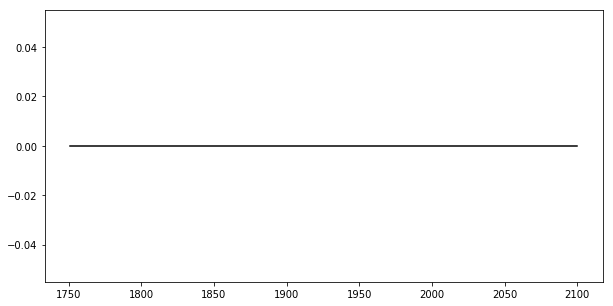

In [14]:
pt = range(tcal.size)

fig = plt.figure(figsize=(10,5))
ax=plt.axes()

# 
ax.plot(tcal[pt], dCatm[pt], color='k', label='Atm')
#ax.plot(tcal[pt], dCoc[pt], color='b', label='Ocean')
ax.plot(tcal[pt], dCla[pt], color='g',label='Land')

ax.legend()
plt.grid()

# add axis labels
plt.ylabel('\DeltaC',fontsize=14)
plt.xlabel('Year',fontsize=14)

# show the plot:
plt.show()

# save the plot
fig.savefig('CO2_resevior_total.png', bbox_inches='tight')
print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()


### Land components

In [ ]:
# if we ran the land (can add an if statement later)


# Plot 1
ax.plot(tcal[pt], res['veg'][pt]*12e-15, color=[0,64,128]/255, label='Live Pools')
ax.plot(tcal[pt], res['lit'][pt]*12e-15, color='g', label='Litter')
ax.plot(tcal[pt], res['cwd'][pt]*12e-15, color=[0,64,128]/255, label='Dead Wood')
ax.plot(tcal[pt], res['som'][pt]*12e-15, color=[0,64,128]/255, label='All Soil')

ax.legend()
plt.grid()

# add axis labels
plt.ylabel('Land Carbon (PgC)',fontsize=14)
plt.xlabel('Year',fontsize=14)

# show the plot:
plt.show()

# save the plot
fig.savefig('CO2_reservoir_land.png', bbox_inches='tight')
print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()



# Plot 2
fig = plt.figure(figsize=(10,5))
ax=plt.axes()

# 
ax.plot(tcal[pt], res['cla'][PL['iLeaf']]*12e-15, color=[64, 128, 0]/255, label='Leaf')
ax.plot(tcal[pt], res['cla'][PL['iWood']]*12e-15, color=[153, 204, 0]/255, label='Wood')
ax.plot(tcal[pt], res['cla'][PL['iRoot']]*12e-15, color=[11, 90, 2]/255, label='Roots')

ax.plot(tcal[pt], res['cla'][PL['iLit1']]*12e-15, color=[25, 131, 0]/255, label='Litter1')
ax.plot(tcal[pt], res['cla'][PL['iLit2']]*12e-15, color=[112, 129, 0]/255, label='Litter2')
ax.plot(tcal[pt], res['cla'][PL['iCWD']]*12e-15, color=[101, 92, 0]/255, label='CWD')
ax.plot(tcal[pt], res['cla'][PL['iSOM1']]*12e-15, color=[156, 98, 0]/255, label='SOM1')
ax.plot(tcal[pt], res['cla'][PL['iSOM2']]*12e-15, color=[170, 167, 55]/255, label='SOM2')
ax.plot(tcal[pt], res['cla'][PL['iSOM3']]*12e-15, color=[255, 0, 0]/255, label='SOM3')


ax.legend()
plt.grid()

# add axis labels
plt.ylabel('Land Carbon (PgC)',fontsize=14)
plt.xlabel('Year',fontsize=14)

# show the plot:
plt.show()

# save the plot
fig.savefig('CO2_reservoir_land.png', bbox_inches='tight')
print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()



